<a href="https://colab.research.google.com/github/JVR27XD/SAM/blob/main/EfficientSAM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/yformer/EfficientSAM.git
%cd EfficientSAM

Cloning into 'EfficientSAM'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 444 (delta 86), reused 65 (delta 57), pack-reused 339 (from 1)
Receiving objects: 100% (444/444), 263.09 MiB | 44.21 MiB/s, done.
Resolving deltas: 100% (256/256), done.
Updating files: 100% (39/39), done.
/content/EfficientSAM


# Definición del Dataset y Carga de Librerías

En este bloque se importan las librerías necesarias para la carga, preprocesado y visualización de datos, así como para el cálculo de métricas de segmentación. También se define una clase personalizada PCBDefectDataset para gestionar las imágenes y sus máscaras de forma compatible con PyTorch.

La clase:

Almacena las rutas de las imágenes y sus máscaras correspondientes.

Lee y convierte cada imagen a formato tensor normalizado en
0,1 0,1.

Convierte las máscaras a formato binario estricto
{0,1}{0,1}, asegurando compatibilidad con métricas y funciones de pérdida.

Devuelve cada elemento como (imagen, máscara, ruta) para su posterior uso en el entrenamiento o evaluación.

Este diseño facilita la integración con DataLoader, permitiendo el procesamiento en lotes y la aplicación de transformaciones adicionales.

In [ ]:
import os, time
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import jaccard_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm

from efficient_sam import build_efficient_sam_vits

class PCBDefectDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform_image=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform_image = transform_image or transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.transform_image(image)

        mask = Image.open(self.mask_paths[idx]).convert("L")
        mask = (transforms.ToTensor()(mask) > 0.5).float()  # binaria estricta
        return image, mask, self.image_paths[idx]


# Generación de máscaras GT desde anotaciones JSON (polígonos)

Automatiza la conversión de anotaciones poligonales (formato tipo LabelMe) a máscaras binarias {0,255}{0,255} alineadas con el tamaño real de cada imagen. Además, valida que las máscaras sean estrictamente binarias y reporta posibles anomalías (máscaras vacías o llenas).
Escalado de polígonos (scale_polygon): ajusta las coordenadas de los vértices desde el tamaño usado en la anotación (imageWidth, imageHeight) al tamaño real de la imagen. Evita desalineaciones cuando las anotaciones no coinciden en resolución con el archivo original.

Recorrido de anotaciones: lee cada .json, obtiene la ruta de la imagen asociada y su tamaño
(𝑊,𝐻)(W,H). Si la imagen no existe, se omite con aviso.

Rasterización: crea una máscara vacía en modo L (8 bits) y dibuja cada polígono escalado con outline=255, fill=255, de modo que el defecto queda en 255 y el fondo en 0.

Validación de binariedad: comprueba los valores únicos de la máscara y, si detecta intermedios, aplica un umbral >127
>127 para forzarla a
{0,255}{0,255}.

Chequeos de contenido: avisa si la máscara resultante está vacía (todo 0) o llena (todo 255), útiles para depuración de etiquetas problemáticas.

Salida y trazabilidad: guarda cada máscara como *_mask.png en generated_masks y acumula image_paths/mask_paths para su uso posterior en Dataset/DataLoader.

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw

def scale_polygon(points, original_width, original_height, target_width, target_height):
    """Escala coordenadas de anotación al tamaño real de la imagen."""
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    return [(round(x * scale_x), round(y * scale_y)) for (x, y) in points]

# 📂 Directorios
labeled_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
os.makedirs(mask_output_dir, exist_ok=True)

image_paths, mask_paths = [], []

# Recorremos anotaciones .json
json_files = [f for f in os.listdir(labeled_dir) if f.lower().endswith(".json")]
for json_file in json_files:
    json_path = os.path.join(labeled_dir, json_file)

    with open(json_path, "r") as f:
        data = json.load(f)

    image_filename = data["imagePath"]
    image_path = os.path.join(labeled_dir, image_filename)
    if not os.path.exists(image_path):
        print(f"⚠ Imagen no encontrada: {image_filename}")
        continue

    # Tamaño real de imagen
    img = Image.open(image_path).convert("RGB")
    img_width, img_height = img.size

    # Tamaño usado en anotación
    ann_width = data.get("imageWidth", img_width)
    ann_height = data.get("imageHeight", img_height)

    # Máscara vacía inicial
    mask = Image.new("L", (img_width, img_height), 0)
    draw = ImageDraw.Draw(mask)

    # Dibujar polígonos escalados
    for shape in data["shapes"]:
        points = shape["points"]
        scaled = scale_polygon(points, ann_width, ann_height, img_width, img_height)
        draw.polygon(scaled, outline=255, fill=255)  # Defecto = 255, fondo = 0

    # Convertir a NumPy para validación
    mask_np = np.array(mask, dtype=np.uint8)

    # Validar binariedad
    vals = np.unique(mask_np)
    if not set(vals).issubset({0, 255}):
        print(f"⚠ Máscara con valores no binarios en {image_filename}: {vals}")
        mask_np = (mask_np > 127).astype(np.uint8) * 255

    # Validar contenido
    if np.all(mask_np == 0):
        print(f"⚠ Máscara vacía: {image_filename}")
    if np.all(mask_np == 255):
        print(f"⚠ Máscara llena: {image_filename}")

    # Guardar máscara binaria estricta
    mask_bin = Image.fromarray(mask_np, mode="L")
    mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
    mask_path = os.path.join(mask_output_dir, mask_filename)
    mask_bin.save(mask_path)

    image_paths.append(image_path)
    mask_paths.append(mask_path)

print(f"✅ Máscaras generadas: {len(mask_paths)}")


/tmp/ipython-input-569887975.py:67: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_bin = Image.fromarray(mask_np, mode="L")


✅ Máscaras generadas: 428


# Validación geométrica y visualización de anotaciones

Verifica que cada polígono anotado (tras el reescalado a la resolución real de la imagen) esté dentro de los límites de la imagen y superpone la máscara resultante sobre la imagen original para una inspección visual rápida.

🟨 Coordenadas reescaladas: x=[1660.0, 1942.0], y=[547.0, 1100.0]
📷 Tamaño imagen: width=2560, height=1440
✅ Polígono dentro de rango. Dibujando...
🟨 Coordenadas reescaladas: x=[717.0, 1230.0], y=[475.0, 958.0]
📷 Tamaño imagen: width=2560, height=1440
✅ Polígono dentro de rango. Dibujando...
🟨 Coordenadas reescaladas: x=[747.0, 994.0], y=[652.0, 901.0]
📷 Tamaño imagen: width=2560, height=1440
✅ Polígono dentro de rango. Dibujando...


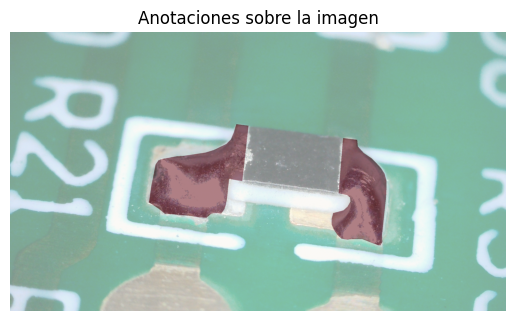

In [ ]:
for shape in data["shapes"]:
    points = shape["points"]
    scaled = scale_polygon(points, ann_width, ann_height, img_width, img_height)

    min_x, max_x = min(x for x, y in scaled), max(x for x, y in scaled)
    min_y, max_y = min(y for x, y in scaled), max(y for x, y in scaled)

    print(f"🟨 Coordenadas reescaladas: x=[{min_x:.1f}, {max_x:.1f}], y=[{min_y:.1f}, {max_y:.1f}]")
    print(f"📷 Tamaño imagen: width={img_width}, height={img_height}")

    if max_x < 0 or max_y < 0 or min_x > img_width or min_y > img_height:
        print("⚠️ Polígono completamente fuera de la imagen.")
    else:
        print("✅ Polígono dentro de rango. Dibujando...")
        draw.polygon(scaled, outline=255, fill=255)  # coherente con máscaras finales

# Visualización
plt.imshow(img)
plt.imshow(np.array(mask), alpha=0.5, cmap='Reds')
plt.title("Anotaciones sobre la imagen")
plt.axis("off")
plt.show()


# Generación y verificación de máscaras (con muestreo visual)
Convierte anotaciones poligonales en archivos máscara binaria alineados con cada imagen, registra rutas para uso posterior y muestra una revisión visual rápida en las primeras 5 muestras para control de calidad.

/tmp/ipython-input-2083326141.py:53: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask = Image.fromarray(mask_np, mode="L")


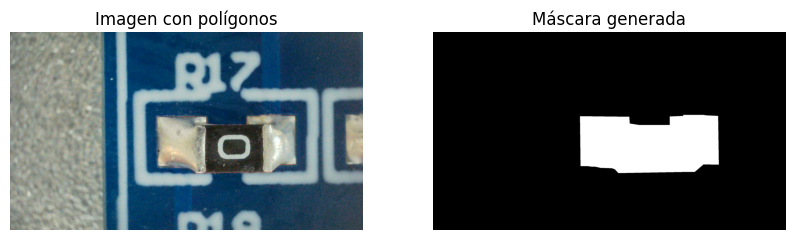

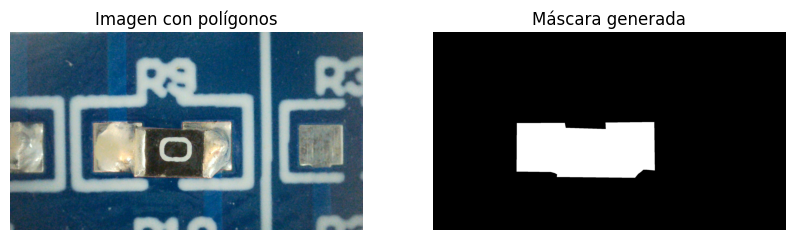

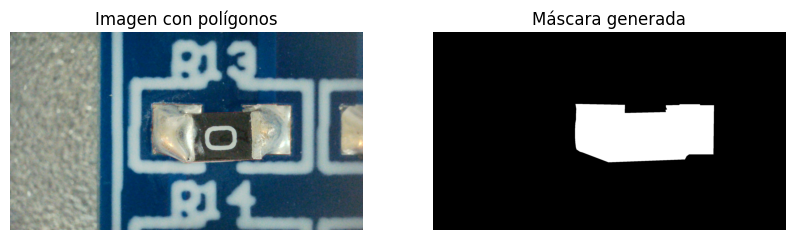

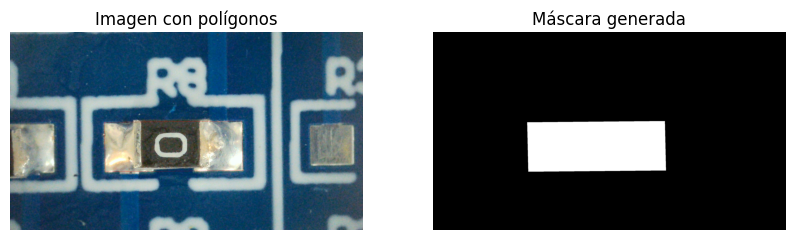

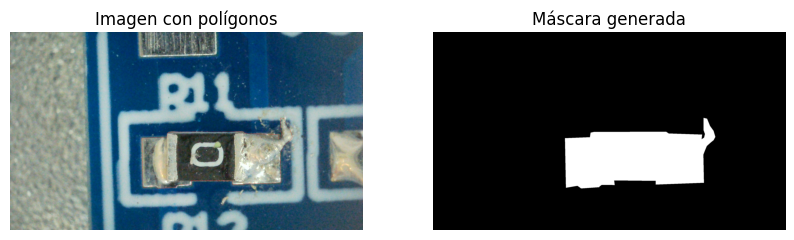

✅ Máscaras generadas: 428


In [ ]:
import os, json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def scale_polygon(points, original_width, original_height, target_width, target_height):
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    return [(round(x * scale_x), round(y * scale_y)) for (x, y) in points]

labeled_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"
mask_output_dir = os.path.join(labeled_dir, "generated_masks")
os.makedirs(mask_output_dir, exist_ok=True)

image_paths, mask_paths = [], []

json_files = [f for f in os.listdir(labeled_dir) if f.endswith(".json")]
for idx, json_file in enumerate(json_files):
    json_path = os.path.join(labeled_dir, json_file)

    with open(json_path, "r") as f:
        data = json.load(f)

    image_filename = data["imagePath"]
    image_path = os.path.join(labeled_dir, image_filename)
    if not os.path.exists(image_path):
        print(f"⚠ Imagen no encontrada: {image_path}")
        continue

    img = Image.open(image_path).convert("RGB")
    img_width, img_height = img.size
    ann_width = data.get("imageWidth", img_width)
    ann_height = data.get("imageHeight", img_height)

    debug_img = img.copy()
    draw_debug = ImageDraw.Draw(debug_img)
    mask = Image.new("L", (img_width, img_height), 0)
    draw_mask = ImageDraw.Draw(mask)

    for shape in data["shapes"]:
        scaled = scale_polygon(shape["points"], ann_width, ann_height, img_width, img_height)
        draw_debug.polygon(scaled, outline="red")
        draw_mask.polygon(scaled, outline=255, fill=255)

    mask_np = np.array(mask, dtype=np.uint8)
    mask_np = (mask_np > 127).astype(np.uint8) * 255

    if np.all(mask_np == 0):
        print(f"⚠ Máscara vacía: {image_filename}")
    if np.all(mask_np == 255):
        print(f"⚠ Máscara llena: {image_filename}")

    mask = Image.fromarray(mask_np, mode="L")
    mask_filename = os.path.splitext(image_filename)[0] + "_mask.png"
    mask_path = os.path.join(mask_output_dir, mask_filename)
    mask.save(mask_path)

    image_paths.append(image_path)
    mask_paths.append(mask_path)

    if idx < 5:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(debug_img)
        plt.title("Imagen con polígonos")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Máscara generada")
        plt.axis("off")
        plt.show()

print(f"✅ Máscaras generadas: {len(mask_paths)}")


In [ ]:
import os
import torch
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
import numpy as np

mask_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled/generated_masks"

problemas = []
total_masks = 0

for fname in os.listdir(mask_dir):
    if fname.lower().endswith(".png"):
        total_masks += 1
        mask_path = os.path.join(mask_dir, fname)
        mask = Image.open(mask_path).convert("L")

        # === Opción 1: comprobar binariedad en {0, 255} ===
        mask_tensor = pil_to_tensor(mask).float()  # float pero sigue en 0–255
        vals = torch.unique(mask_tensor)
        if not set(vals.tolist()).issubset({0.0, 255.0}):
            problemas.append((fname, vals.tolist()))

        # === Opción 2: comprobar binariedad en {0, 1} ===
        mask_bin = (mask_tensor > 127).float()
        vals_bin = torch.unique(mask_bin)
        if not set(vals_bin.tolist()).issubset({0.0, 1.0}):
            print(f"⚠ {fname} → valores no binarios después de umbralizar: {vals_bin.tolist()}")

print(f"🔍 Total máscaras revisadas: {total_masks}")
print(f"⚠ Máscaras con valores no binarios (0/255): {len(problemas)}")

if problemas:
    print("Ejemplos de máscaras problemáticas:")
    for name, vals in problemas[:5]:
        print(f" - {name}: {vals}")


🔍 Total máscaras revisadas: 428
⚠ Máscaras con valores no binarios (0/255): 0


In [ ]:
!unzip weights/efficient_sam_vits.pt.zip -d weights/
import os

if os.path.exists("weights/efficient_sam_vits.pt"):
    print("✅ Archivo de pesos encontrado.")
else:
    print("❌ No se encontró el archivo de pesos.")


Archive:  weights/efficient_sam_vits.pt.zip
  inflating: weights/efficient_sam_vits.pt  
  inflating: weights/__MACOSX/._efficient_sam_vits.pt  
✅ Archivo de pesos encontrado.


In [ ]:
import os
import sys
import torch

# === 1. Asegurar que la carpeta EfficientSAM está en sys.path ===
repo_dir = "/content/EfficientSAM"  # Ajusta si está en otro sitio
if not os.path.exists(repo_dir):
    raise FileNotFoundError(f"No se encontró el repo en: {repo_dir}")
sys.path.append(repo_dir)

# === 2. Importar constructores de modelos ===
from efficient_sam import build_efficient_sam_vits, build_efficient_sam_vitt

# === 3. Seleccionar modelo ===
modelo = "small"  # "tiny" o "small"
if modelo == "small":
    model = build_efficient_sam_vits()
    checkpoint_path = os.path.join(repo_dir, "weights", "efficient_sam_vits.pt")
else:
    model = build_efficient_sam_vitt()
    checkpoint_path = os.path.join(repo_dir, "weights", "efficient_sam_vitt.pt")

# === 4. Comprobar existencia de checkpoint ===
if not os.path.exists(checkpoint_path):
    raise FileNotFoundError(f"No se encontró el checkpoint en: {checkpoint_path}")

# === 5. Cargar pesos con detección automática de clave ===
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint.get("model", checkpoint.get("state_dict", checkpoint))
model.load_state_dict(state_dict, strict=True)

# === 6. Preparar para inferencia ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === 7. Confirmación ===
print(f"✅ Modelo EfficientSAM-ViT-{modelo.capitalize()} cargado correctamente en {device}")
print(f"📦 Nº de parámetros: {sum(p.numel() for p in model.parameters()):,}")



✅ Modelo EfficientSAM-ViT-Small cargado correctamente en cuda
📦 Nº de parámetros: 26,413,028


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import sample

labeled_dir = "/content/drive/MyDrive/Colab Notebooks/SolDef_AI/Labeled"
mask_dir = os.path.join(labeled_dir, "generated_masks")

image_files = [f for f in os.listdir(labeled_dir) if f.lower().endswith((".jpg", ".png"))]
problemas = []

for img_file in image_files:
    mask_file = os.path.splitext(img_file)[0] + "_mask.png"
    mask_path = os.path.join(mask_dir, mask_file)
    img_path = os.path.join(labeled_dir, img_file)

    if not os.path.exists(mask_path):
        problemas.append((img_path, "❌ Máscara no encontrada"))
        continue

    mask = Image.open(mask_path).convert("L")
    mask_np = np.array(mask)

    # Chequeo binariedad
    valores_unicos = np.unique(mask_np)
    if not set(valores_unicos).issubset({0, 255}):
        problemas.append((img_path, f"⚠ Máscara no binaria: {valores_unicos}"))
        continue  # Evitamos más chequeos si ya falla binariedad

    # Umbralizar para evitar errores por escala de grises
    bin_mask = (mask_np > 127).astype(np.uint8) * 255

    # Chequeo de contenido
    defect_pixels = np.sum(bin_mask == 255)
    if defect_pixels == 0:
        problemas.append((img_path, "⚠ Máscara vacía (sin defectos)"))
    elif defect_pixels == mask_np.size:
        problemas.append((img_path, "⚠ Máscara llena (todo defecto)"))

# Resumen
print(f"🔍 Total imágenes: {len(image_files)}")
print(f"⚠ Problemas detectados: {len(problemas)} ({100*len(problemas)/len(image_files):.1f}%)")

# Visualización aleatoria de hasta 5 problemas
for path, desc in sample(problemas, min(5, len(problemas))):
    print(f"{desc} → {path}")
    img = Image.open(path).convert("RGB")
    mask_path = os.path.join(mask_dir, os.path.splitext(os.path.basename(path))[0] + "_mask.png")
    mask = Image.open(mask_path).convert("L")

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagen")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(desc)
    plt.axis("off")
    plt.show()


🔍 Total imágenes: 428
⚠ Problemas detectados: 0 (0.0%)


# Evaluación de EfficientSAM con distintos prompts (point, box, combo, multi)
Evaluación sobre todas las imágenes:
(1) preprocesa y normaliza entradas,
(2) genera prompts a partir del GT (punto central, caja y multipuntos),
(3) infiere máscaras con EfficientSAM,
(4) alinea la GT al mismo espacio,
(5) calcula métricas (IoU, Dice, Precisión, Recall),
(6) mide tiempo/VRAM,
(7) muestra visualizaciones comparativas.

  0%|          | 0/428 [00:00<?, ?it/s]

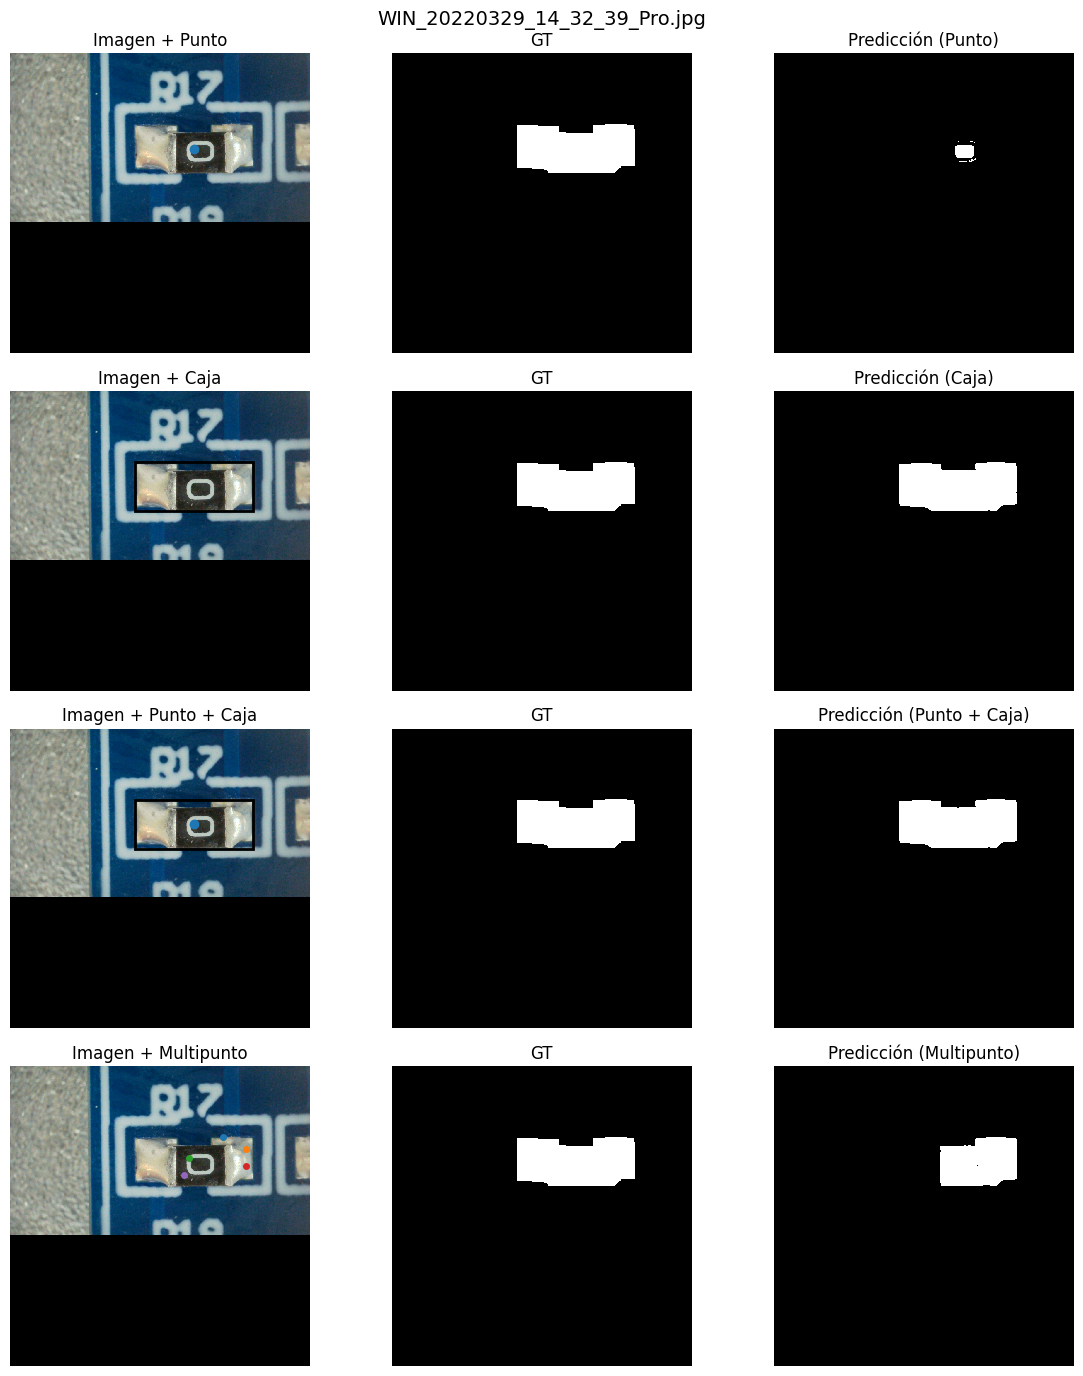

  0%|          | 1/428 [00:03<23:53,  3.36s/it]

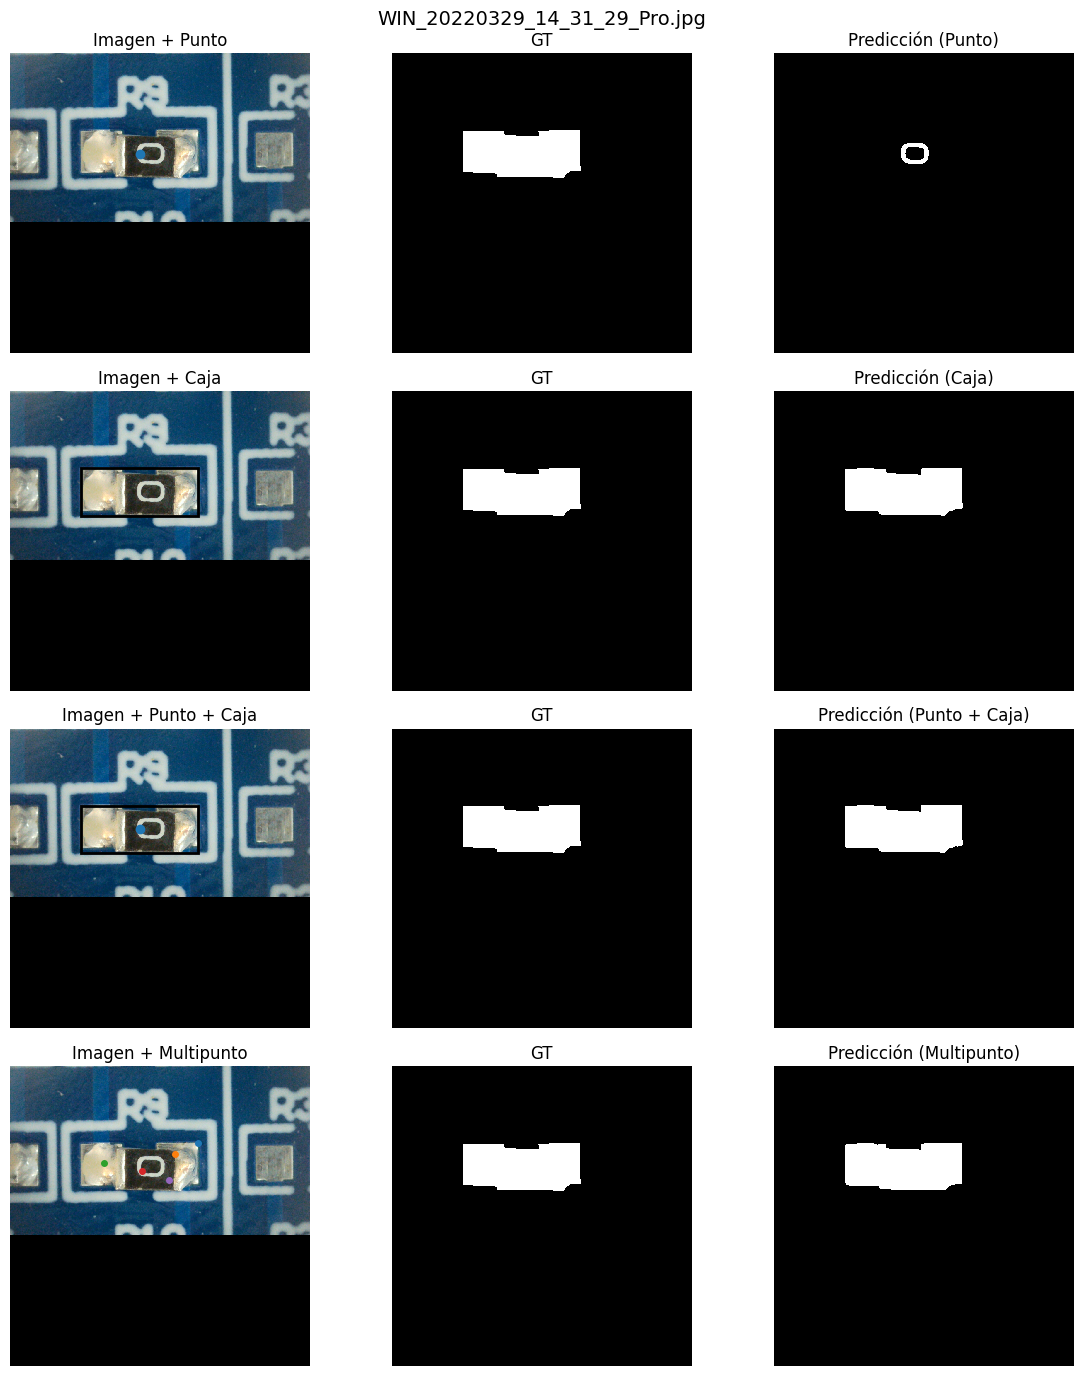

  0%|          | 2/428 [00:07<26:28,  3.73s/it]

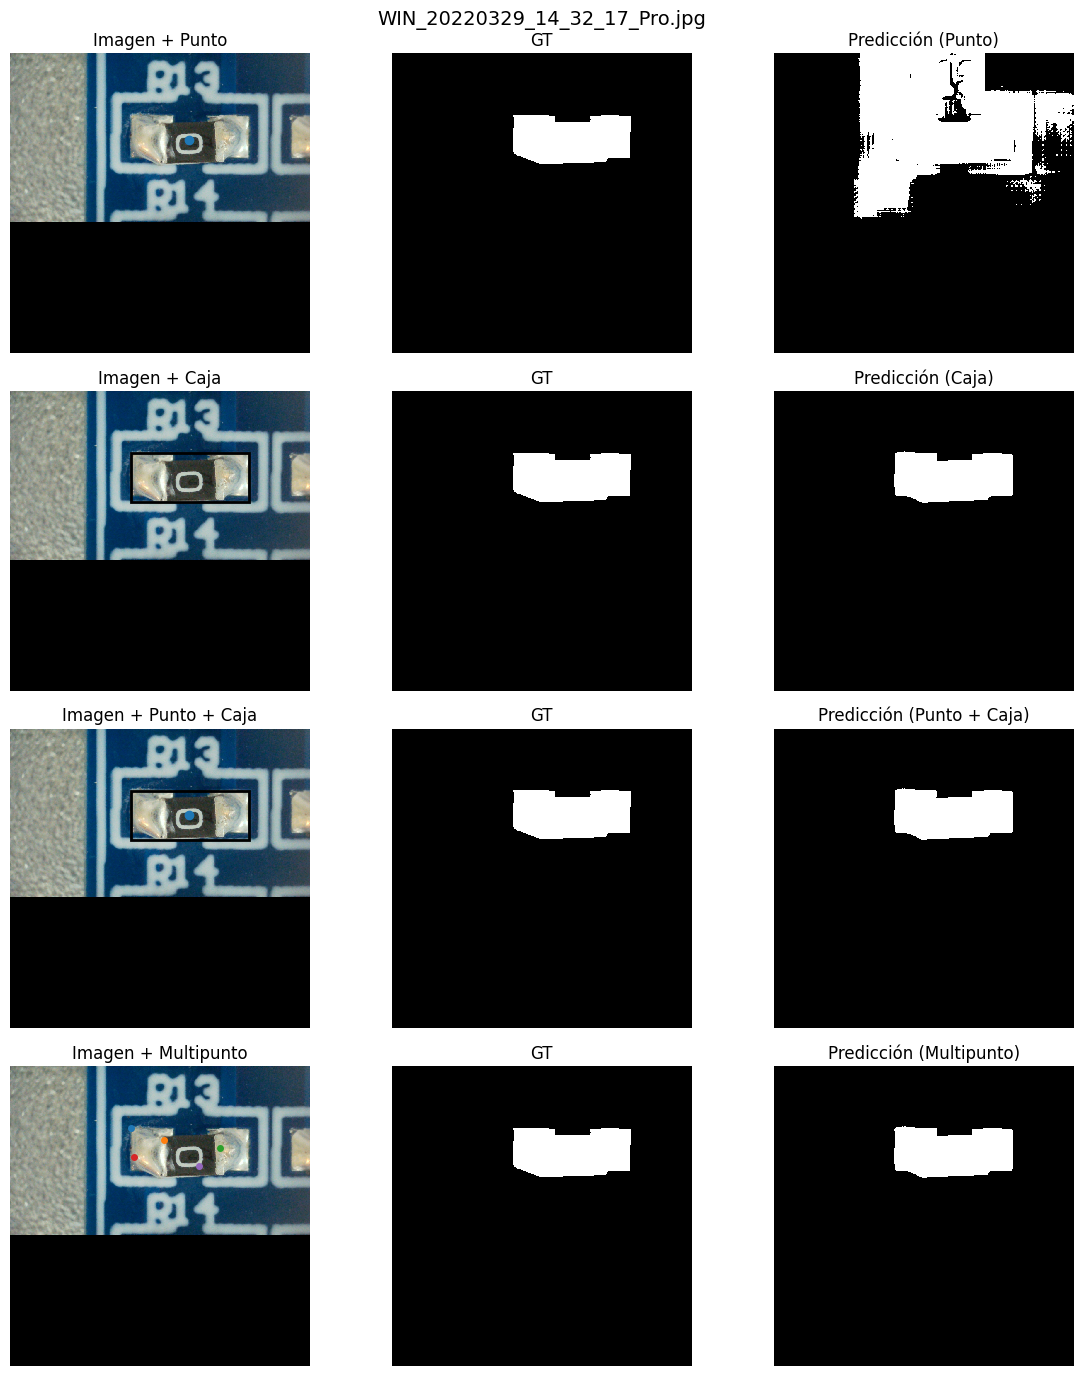

100%|██████████| 428/428 [09:38<00:00,  1.35s/it]


📊 Métricas promedio EfficientSAM (por modalidad):

— POINT
IoU: 0.1357 ± 0.1955
Dice: 0.1959 ± 0.2535
Precisión: 0.5398 ± 0.4708
Recall: 0.2056 ± 0.3212

— BOX
IoU: 0.7276 ± 0.2600
Dice: 0.8143 ± 0.1869
Precisión: 0.7398 ± 0.2676
Recall: 0.9807 ± 0.0274

— COMBO
IoU: 0.7283 ± 0.2617
Dice: 0.8143 ± 0.1883
Precisión: 0.7389 ± 0.2678
Recall: 0.9825 ± 0.0305

— MULTI
IoU: 0.6994 ± 0.2472
Dice: 0.7970 ± 0.1805
Precisión: 0.7586 ± 0.2650
Recall: 0.9308 ± 0.1293

⏱ Tiempo promedio: 1.339 ± 0.208 s
💾 VRAM promedio: 1092.01 ± 0.82 MB


In [ ]:
import torch, numpy as np, time, os, matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import jaccard_score, precision_score, recall_score
from PIL import Image
from torchvision import transforms as T

plt.rcParams['image.interpolation'] = 'nearest'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    model.eval()
except:
    pass

IMG_SIZE = 1024
THR = 0.5  # umbral binarización

# --- Transform: NORMALIZACIÓN IMAGENET ---
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# --- Helpers ---
def dice_coef(y_true, y_pred):
    return 2*(y_true*y_pred).sum()/(y_true.sum()+y_pred.sum()+1e-7)

def pad_to_square_1024(img_pil):
    w, h = img_pil.size
    scale = IMG_SIZE / max(w, h)
    new_w, new_h = int(round(w*scale)), int(round(h*scale))
    resized = img_pil.resize((new_w, new_h), Image.BILINEAR)
    canvas = Image.new("RGB", (IMG_SIZE, IMG_SIZE))
    canvas.paste(resized, (0, 0))
    pad_x, pad_y = 0, 0
    return canvas, scale, pad_x, pad_y, (new_w, new_h)

def to_input_padded_xy(xy_pts, scale, pad_x=0, pad_y=0):
    xy = np.asarray(xy_pts, dtype=np.float32).copy()
    xy[:, 0] = xy[:, 0]*scale + pad_x
    xy[:, 1] = xy[:, 1]*scale + pad_y
    return xy

def clamp_xy(xy, W, H):
    xy = np.asarray(xy, dtype=np.float32).copy()
    xy[:, 0] = np.clip(np.round(xy[:, 0]), 0, W-1)
    xy[:, 1] = np.clip(np.round(xy[:, 1]), 0, H-1)
    return xy

def ensure_1024(mask_np: np.ndarray) -> np.ndarray:
    mask_np = (mask_np > 0).astype(np.uint8)
    if mask_np.shape != (IMG_SIZE, IMG_SIZE):
        mask_np = np.array(Image.fromarray(mask_np*255).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))//255
    return mask_np

def logits_to_binary(pred_out, thr=THR):
    """Convierte salida de predict_masks en máscara binaria."""
    if isinstance(pred_out, (tuple, list)):
        masks, ious = pred_out[0], pred_out[1]
        masks_f = masks.reshape(-1, *masks.shape[-2:])
        ious_f  = ious.reshape(-1)
        idx = torch.argmax(ious_f)
        mask_tensor = masks_f[idx]
    else:
        mask_tensor = pred_out

    if mask_tensor.ndim == 3:
        mask_tensor = mask_tensor[0]
    if mask_tensor.min() < 0 or mask_tensor.max() > 1:
        mask_tensor = mask_tensor.sigmoid()
    return (mask_tensor > thr).to(torch.uint8).cpu().numpy()

def pad_mask_to_square_1024(mask_pil, scale, pad_x=0, pad_y=0):
    """Redimensiona y paddea la máscara igual que la imagen."""
    w, h = mask_pil.size
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    resized_mask = mask_pil.resize((new_w, new_h), Image.NEAREST)
    canvas = Image.new("L", (IMG_SIZE, IMG_SIZE), 0)
    canvas.paste(resized_mask, (pad_x, pad_y))
    return np.array(canvas) > 127

# --- Acumuladores ---
inference_times, vram_usages = [], []
metrics = {m: {"iou": [], "dice": [], "prec": [], "rec": []} for m in ["point","box","combo","multi"]}

for i in tqdm(range(len(image_paths))):
    t0 = time.time()
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    img_pil = Image.open(image_paths[i]).convert("RGB")
    msk_pil = Image.open(mask_paths[i]).convert("L")
    gt_bin = (np.array(msk_pil) > 127)
    coords = np.argwhere(gt_bin)
    if coords.size == 0:
        print(f"⚠ Sin anotación en: {image_paths[i]}")
        continue

    # Centro y caja originales
    y_c, x_c = coords.mean(axis=0).astype(int)
    x0_o, y0_o = coords[:,1].min(), coords[:,0].min()
    x1_o, y1_o = coords[:,1].max(), coords[:,0].max()

    # Preproceso
    img_in, scale, pad_x, pad_y, _ = pad_to_square_1024(img_pil)
    inp = transform(img_in).unsqueeze(0).to(device)

    # Prompts
    pt_xy_in  = clamp_xy(to_input_padded_xy(np.array([[x_c, y_c]]), scale, pad_x, pad_y), IMG_SIZE, IMG_SIZE)
    box_xy_in = clamp_xy(to_input_padded_xy(np.array([[x0_o, y0_o],[x1_o, y1_o]]), scale, pad_x, pad_y), IMG_SIZE, IMG_SIZE)
    step = max(1, len(coords)//5)
    sel = coords[::step][:5] if step > 0 else np.array([[y_c, x_c]])
    mp_xy_in  = clamp_xy(to_input_padded_xy(np.stack([sel[:,1], sel[:,0]], axis=1), scale, pad_x, pad_y), IMG_SIZE, IMG_SIZE)

    # Tensores + labels
    pt4    = torch.from_numpy(pt_xy_in).unsqueeze(0).unsqueeze(0).to(device)
    lbl4   = torch.tensor([[[1]]], dtype=torch.int64, device=device)
    box4   = torch.from_numpy(box_xy_in).unsqueeze(0).unsqueeze(0).to(device)
    boxlb4 = torch.tensor([[[2, 3]]], dtype=torch.int64, device=device)
    combo4 = torch.cat([pt4, box4], dim=2)
    combol4= torch.tensor([[[1, 2, 3]]], dtype=torch.int64, device=device)
    multi4 = torch.from_numpy(mp_xy_in).unsqueeze(0).unsqueeze(0).to(device)
    multil4= torch.tensor([[[1]*mp_xy_in.shape[0]]], dtype=torch.int64, device=device)

    with torch.inference_mode():
        emb = model.image_encoder(inp)
        sizes = (IMG_SIZE, IMG_SIZE, IMG_SIZE, IMG_SIZE)

        mask_point = logits_to_binary(model.predict_masks(emb, pt4,    lbl4,    True, *sizes))
        mask_box   = logits_to_binary(model.predict_masks(emb, box4,   boxlb4,  True, *sizes))
        mask_combo = logits_to_binary(model.predict_masks(emb, combo4, combol4, True, *sizes))
        mask_multi = logits_to_binary(model.predict_masks(emb, multi4, multil4, True, *sizes))

    # GT alineada
    gt_padded = pad_mask_to_square_1024(msk_pil, scale, pad_x, pad_y)
    y_true = gt_padded.flatten().astype(np.uint8)

    preds = {"point": mask_point, "box": mask_box, "combo": mask_combo, "multi": mask_multi}
    for name, m in preds.items():
        y_pred = ensure_1024(m).flatten()
        metrics[name]["iou"].append(jaccard_score(y_true, y_pred, zero_division=0))
        metrics[name]["dice"].append(dice_coef(y_true, y_pred))
        metrics[name]["prec"].append(precision_score(y_true, y_pred, zero_division=0))
        metrics[name]["rec"].append(recall_score(y_true, y_pred, zero_division=0))

    inference_times.append(time.time() - t0)
    if torch.cuda.is_available():
        vram_usages.append(torch.cuda.max_memory_allocated() / 1024**2)

    # --- Visualización ---
    if i < 3:
        vis_bin = {k: ensure_1024(v) for k, v in preds.items()}
        order = [("Punto", "point"), ("Caja", "box"), ("Punto + Caja", "combo"), ("Multipunto", "multi")]

        fig, axs = plt.subplots(4, 3, figsize=(12, 14))
        for r, (title, key) in enumerate(order):
            axs[r, 0].imshow(img_in)
            if key == "point":
                x, y = pt_xy_in[0]
                axs[r, 0].plot(x, y, 'o', markersize=6)
            elif key == "box":
                (x0, y0), (x1, y1) = box_xy_in
                rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=2)
                axs[r, 0].add_patch(rect)
            elif key == "combo":
                x, y = pt_xy_in[0]
                axs[r, 0].plot(x, y, 'o', markersize=6)
                (x0, y0), (x1, y1) = box_xy_in
                rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, linewidth=2)
                axs[r, 0].add_patch(rect)
            else:
                for (x, y) in mp_xy_in:
                    axs[r, 0].plot(int(x), int(y), 'o', markersize=4)
            axs[r, 0].set_title(f"Imagen + {title}")
            axs[r, 0].axis('off')

            axs[r, 1].imshow(gt_padded.astype(np.uint8), cmap='gray', vmin=0, vmax=1)
            axs[r, 1].set_title("GT")
            axs[r, 1].axis('off')

            axs[r, 2].imshow(vis_bin[key].astype(np.uint8), cmap='gray', vmin=0, vmax=1)
            axs[r, 2].set_title(f"Predicción ({title})")
            axs[r, 2].axis('off')

        fig.suptitle(os.path.basename(image_paths[i]), fontsize=14)
        plt.tight_layout()
        plt.show()

# --- Promedios ---
print("\n📊 Métricas promedio EfficientSAM (por modalidad):")
for name in ["point","box","combo","multi"]:
    iou_m, iou_s = np.mean(metrics[name]["iou"]),  np.std(metrics[name]["iou"])
    dic_m, dic_s = np.mean(metrics[name]["dice"]), np.std(metrics[name]["dice"])
    pre_m, pre_s = np.mean(metrics[name]["prec"]), np.std(metrics[name]["prec"])
    rec_m, rec_s = np.mean(metrics[name]["rec"]),  np.std(metrics[name]["rec"])
    print(f"\n— {name.upper()}")
    print(f"IoU: {iou_m:.4f} ± {iou_s:.4f}")
    print(f"Dice: {dic_m:.4f} ± {dic_s:.4f}")
    print(f"Precisión: {pre_m:.4f} ± {pre_s:.4f}")
    print(f"Recall: {rec_m:.4f} ± {rec_s:.4f}")

print(f"\n⏱ Tiempo promedio: {np.mean(inference_times):.3f} ± {np.std(inference_times):.3f} s")
if vram_usages:
    print(f"💾 VRAM promedio: {np.mean(vram_usages):.2f} ± {np.std(vram_usages):.2f} MB")



